In [1]:
# Import packages
import os
import cv2
import numpy as np
import sys
import time
import fnmatch
import argparse
import matplotlib.pyplot as plt
import importlib.util
import tensorly as tl
from tensorflow.lite.python.interpreter import Interpreter

MODEL_DIR = 'coco_mobilenet'
MODEL_NAME = 'detect.tflite'
LABELMAP_NAME = 'labelmap.txt'
min_conf_threshold = 0.7

# Get path to current working directory
CWD_PATH = os.path.dirname(os.getcwd())

# Path to .tflite file, which contains the model that is used for object detection
PATH_TO_CKPT = os.path.join(CWD_PATH, MODEL_DIR, MODEL_NAME)

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH, MODEL_DIR, LABELMAP_NAME)

# Load the label map
with open(PATH_TO_LABELS, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

# First label is '???', which has to be removed.
if labels[0] == '???':
    del (labels[0])

# Load the Tensorflow Lite model.
interpreter = Interpreter(model_path=PATH_TO_CKPT)

interpreter.allocate_tensors()

# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

floating_model = (input_details[0]['dtype'] == np.float32)

input_mean = 127.5
input_std = 127.5

def locate_videos(VIDEO_DIR_PATH):
    # Path to video dataset
    VIDEO_DIR = VIDEO_DIR_PATH
    CWD_PATH = os.getcwd()

    VIDEO_PATH = os.path.join(CWD_PATH, VIDEO_DIR)

    # Create a list with all the file names
    vids_list = os.listdir(VIDEO_DIR)

    # Establish a pattern to detect only videos
    pattern = "*.mp4"

    # Create a list of names of every file in the dataset
    filename_list = []
    for file in vids_list:
        if fnmatch.fnmatch(file, pattern):
            filename_list.append(file)

    return filename_list, VIDEO_PATH

# Loop through each video and instantiate windows
def capture_frames(video, VIDEO_PATH, max_frames=100):

    # for video in filename_list[0]:

    # initialize the video
    capture = cv2.VideoCapture(f'{VIDEO_PATH}{video}')

    # Initialize an empty array
    frames_array = []
    frame_number = 0

    # Create window
    # cv2.namedWindow('Object detector', cv2.WINDOW_NORMAL)

    while capture.isOpened() and frame_number < max_frames:
        # Capture the video frame
        ret, frame = capture.read()

        if not ret:
            break

        # Acquire frame and resize to expected shape [1xHxWx3]
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_resized = cv2.resize(frame_rgb, (width, height))
        input_data = np.expand_dims(frame_resized, axis=0)

        # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
        if floating_model:
            input_data = (np.float32(input_data) - input_mean) / input_std

        # Perform the actual detection by running the model with the image as input
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        # Retrieve detection results
        # Bounding box coordinates of detected objects
        boxes = interpreter.get_tensor(output_details[0]['index'])[0]

        # Class index of detected objects
        classes = interpreter.get_tensor(output_details[1]['index'])[0]

        # Confidence of detected objects
        scores = interpreter.get_tensor(output_details[2]['index'])[0]

        frames_array.append(input_data)
        frame_number += 1

        # Press 'q' to quit
        if cv2.waitKey(1) == ord('q'):
            capture.release()
            cv2.destroyAllWindows()
            break

    return capture, frame, boxes, classes, scores, (frames_array)

# Detect humans within the windows and create ROI
def detect_humans(capture, frame, boxes, classes, scores):

    # Get the dimensions of the video used for rectangle creation
    imW = capture.get(3)  # float `width`
    imH = capture.get(4)  # float `height`

    # Locate indexes for persons classes only
    if 0 in classes:
        idx_list = [idx for idx, val in enumerate(classes) if val == 0]

        # Reassign bounding boxes only to detected people
        boxes = [boxes[i] for i in idx_list]

        # Loop over all detections and draw detection box if confidence is above minimum threshold
        for i in range(len(scores)):
            if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):

                # Get bounding box coordinates and draw box for all people detected
                if len(boxes) > 0:
                    # Find the top-most top
                    top = min([i[0] for i in boxes])
                    # Find the left-most left
                    left = min([i[1] for i in boxes])
                    # Find the bottom-most bottom
                    bottom = max([i[2] for i in boxes])
                    # Find the right-most right
                    right = max([i[3] for i in boxes])

                    # Convert bounding lines into coordinates
                    # Interpreter can return coordinates that are outside of image dimensions,
                    # Need to force them to be within image using max() and min()
                    ymin = int(max(1, (top * imH)))
                    xmin = int(max(1, (left * imW)))
                    ymax = int(min(imH, (bottom * imH)))
                    xmax = int(min(imW, (right * imW)))

                    # Build a rectangle
                    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax),
                                  (10, 255, 0), 2)

                    # Save cropped area into a variable for each frame
                    rectangle = frame[ymin:ymax, xmin:xmax]

                    # cv2.imshow('Object detector', frame)

    return rectangle

# if __name__ == "__main__":

In [2]:
ls

Testing cropper.ipynb
dehaja_violence_detection_model.ipynb
lukas_basic_violence_detection_model.ipynb
lukas_coco_mobilenetv1.ipynb
lukas_haar_cascade_model.ipynb


In [3]:
print("Importing and reading done")
# Get the video path √
test_PATH = '../raw_data/videos_dataset/Real Life Violence Dataset/NonViolence/'
print("Locating videos done")
# Slice the video into frames (Better to slice into tensors)
capture, frame, boxes, classes, scores, people_array = capture_frames(
    'NV_566.mp4', test_PATH)

print("number of frames: ", len(people_array))

# Create tensors from matrices
people_tensor = tl.tensor(people_array)

print("shape of tensors: ", people_tensor.shape)
# Call the model to detect humans for each frame
# Then append the output into a list of pictures
pictures_list = []
for i in people_array:
    rectangle = detect_humans(capture, frame, boxes, classes, scores)
    pictures_list.append(rectangle)
    i += 1

# Output the list of pictures
print("size of picture list: ", len(pictures_list))
cv2.imshow('Object detector', pictures_list[0])


Importing and reading done
Locating videos done
number of frames:  100
shape of tensors:  (100, 1, 300, 300, 3)
size of picture list:  100


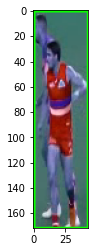

In [11]:
plt.imshow(pictures_list[99])

In [5]:
pictures_list[2].shape

(172, 43, 3)

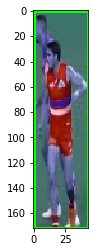

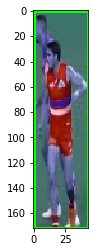

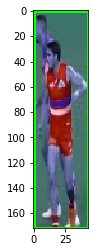

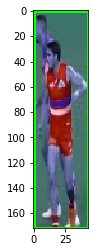

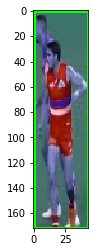

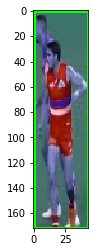

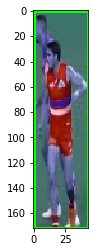

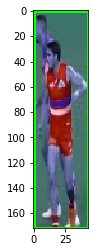

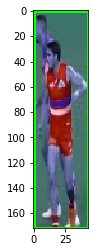

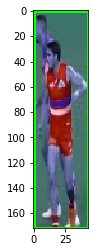

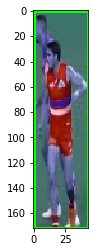

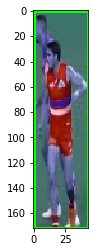

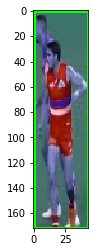

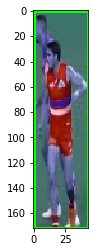

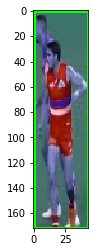

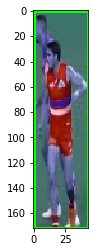

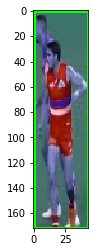

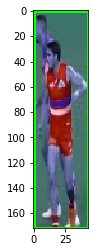

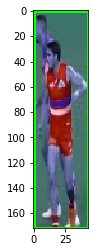

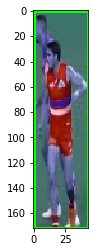

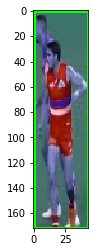

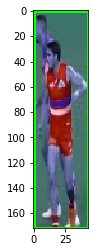

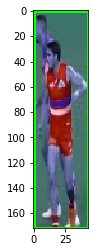

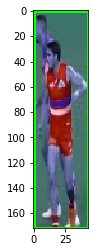

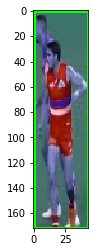

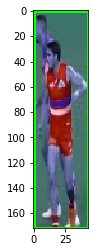

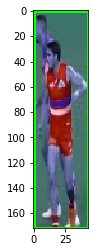

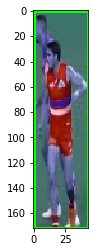

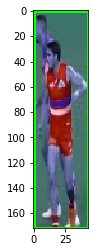

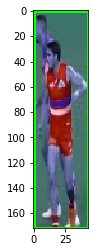

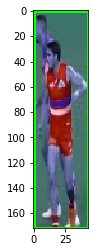

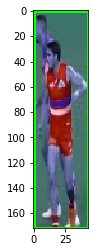

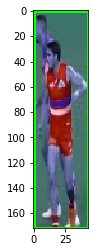

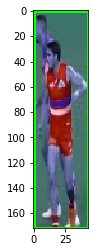

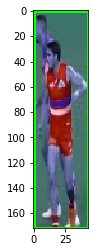

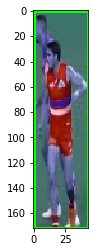

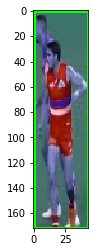

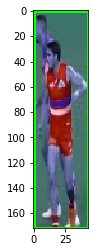

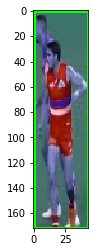

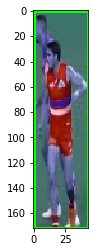

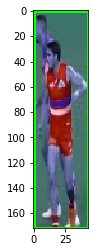

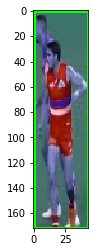

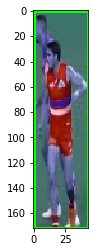

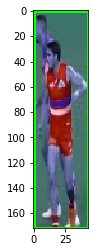

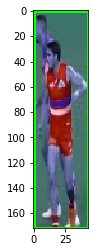

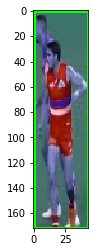

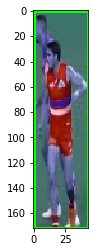

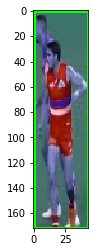

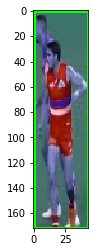

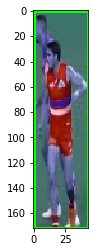

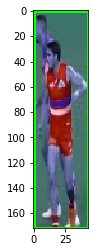

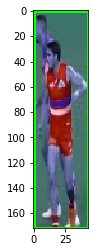

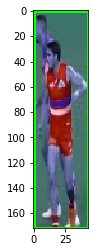

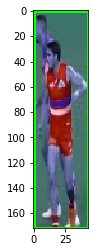

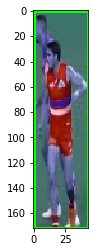

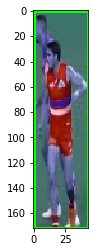

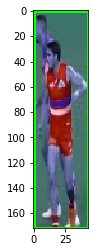

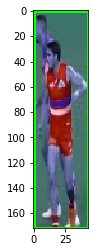

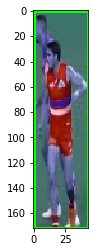

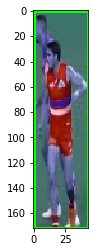

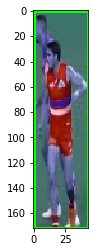

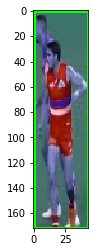

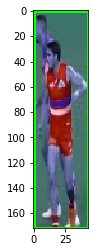

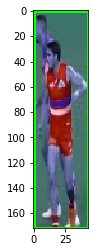

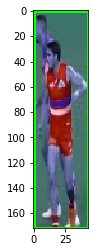

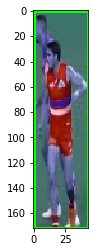

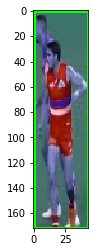

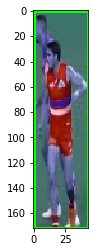

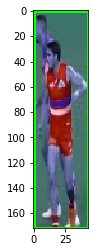

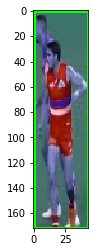

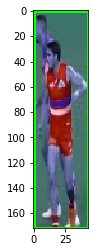

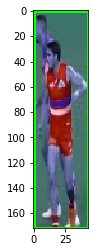

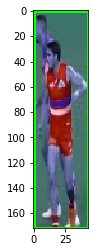

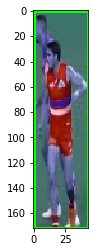

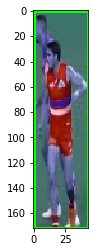

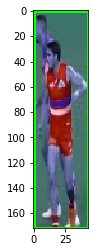

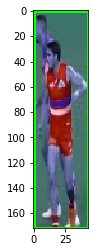

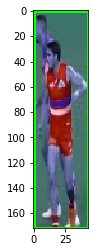

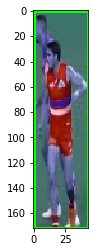

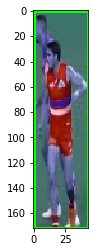

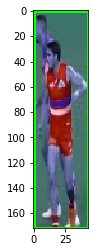

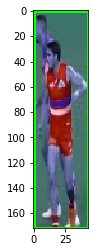

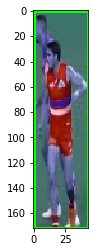

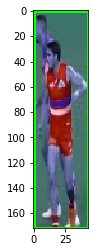

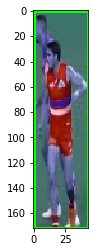

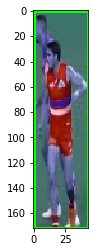

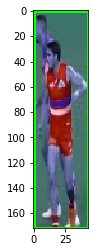

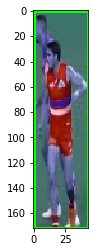

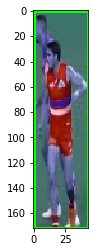

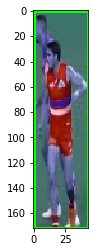

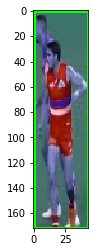

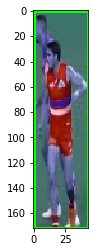

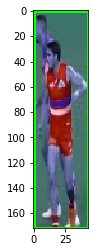

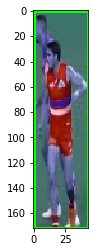

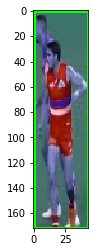

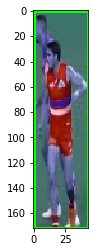

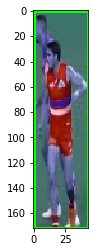

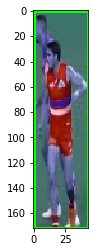

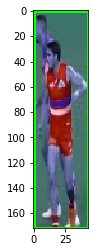

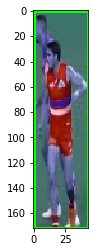

In [7]:
from matplotlib import pyplot as plt

for i in pictures_list:
    plt.imshow(i, interpolation='nearest')
    plt.show();